# Motion Analysis Dashboard - Dual-Panel Visualization

**Purpose**: Interactive 3D stickman animation synchronized with kinematic features

**Features**:
- Mode A: Kinematic Chain Velocity (multi-joint velocity tracking)
- Mode B: Convex Hull Volume (body envelope over time)
- 3D Stickman with Green Bubble (convex hull visualization)
- Frame synchronization with vertical time pointer

**Data Source**: Processed CSV from motion capture pipeline (filtered, gap-filled)

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Path setup
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from config import CONFIG

print("✅ Imports loaded successfully")
print(f"Project root: {PROJECT_ROOT}")

✅ Imports loaded successfully
Project root: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga


## Configuration Panel

**Modify these variables to customize the dashboard**

In [2]:
# =============================================================================
# USER CONFIGURATION
# =============================================================================

# --- Mode Selection ---
MODE = 'velocity'  # Options: 'velocity' or 'volume'

# --- Kinematic Chain (for velocity mode) ---
JOINTS_TO_PLOT = ['RightShoulder', 'RightElbow', 'RightWrist', 'RightHand']
# Alternative chains:
# JOINTS_TO_PLOT = ['LeftShoulder', 'LeftElbow', 'LeftWrist', 'LeftHand']
# JOINTS_TO_PLOT = ['RightHip', 'RightKnee', 'RightAnkle', 'RightFoot']

# --- Frame Range ---
START_FRAME = 0       # Start frame index (0 = beginning)
END_FRAME = 1200      # End frame index (None = use all frames)
STEP = 2              # Frame increment (1 = every frame, 2 = every 2nd frame, etc.)

# --- Skeleton Definition ---
# Define which joints connect to form the skeleton
SKELETON_MAP = [
    # Spine
    ('Pelvis', 'LowerBack'),
    ('LowerBack', 'UpperBack'),
    ('UpperBack', 'Chest'),
    ('Chest', 'Neck'),
    ('Neck', 'Head'),
    
    # Right arm
    ('Chest', 'RightShoulder'),
    ('RightShoulder', 'RightElbow'),
    ('RightElbow', 'RightWrist'),
    ('RightWrist', 'RightHand'),
    
    # Left arm
    ('Chest', 'LeftShoulder'),
    ('LeftShoulder', 'LeftElbow'),
    ('LeftElbow', 'LeftWrist'),
    ('LeftWrist', 'LeftHand'),
    
    # Right leg
    ('Pelvis', 'RightHip'),
    ('RightHip', 'RightKnee'),
    ('RightKnee', 'RightAnkle'),
    ('RightAnkle', 'RightFoot'),
    
    # Left leg
    ('Pelvis', 'LeftHip'),
    ('LeftHip', 'LeftKnee'),
    ('LeftKnee', 'LeftAnkle'),
    ('LeftAnkle', 'LeftFoot'),
]

# --- Visualization Settings ---
FPS = 30              # Frames per second for animation
FIGSIZE = (16, 8)     # Figure size (width, height)
DPI = 100             # Resolution

# --- Data Source ---
csv_filename = Path(CONFIG['current_csv']).stem
RUN_ID = csv_filename
DERIV_DIR = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_04_filtering")
INPUT_FILE = Path(DERIV_DIR) / f"{RUN_ID}__filtered.parquet"

print("Configuration loaded:")
print(f"  Mode: {MODE}")
print(f"  Frame range: {START_FRAME} to {END_FRAME} (step={STEP})")
print(f"  Kinematic chain: {JOINTS_TO_PLOT}")
print(f"  Data source: {INPUT_FILE.name}")

Configuration loaded:
  Mode: velocity
  Frame range: 0 to 1200 (step=2)
  Kinematic chain: ['RightShoulder', 'RightElbow', 'RightWrist', 'RightHand']
  Data source: 734_T1_P1_R1_Take 2025-12-01 02.18.27 PM__filtered.parquet


## Data Loading and Preprocessing

In [3]:
# =============================================================================
# DATA LOADING
# =============================================================================

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"Input file not found: {INPUT_FILE}\nPlease run notebook 04_filtering.ipynb first.")

# Load data
df = pd.read_parquet(INPUT_FILE)
print(f"✅ Loaded {len(df)} frames from {INPUT_FILE.name}")

# Extract position columns (markers ending with __px, __py, __pz)
pos_cols = [col for col in df.columns if col.endswith(('__px', '__py', '__pz'))]
marker_names = sorted(list(set([col.rsplit('__', 1)[0] for col in pos_cols])))

print(f"✅ Found {len(marker_names)} markers: {marker_names[:5]}...")

# Apply frame range
if END_FRAME is None:
    END_FRAME = len(df)
else:
    END_FRAME = min(END_FRAME, len(df))

df_subset = df.iloc[START_FRAME:END_FRAME:STEP].copy()
print(f"✅ Selected {len(df_subset)} frames for visualization (every {STEP} frame(s))")

# Get sampling frequency
FS = CONFIG.get('FS_TARGET', 120.0)
dt = 1.0 / FS * STEP  # Adjusted for frame step
print(f"✅ Sampling frequency: {FS} Hz (dt = {dt:.4f}s with step={STEP})")

✅ Loaded 30798 frames from 734_T1_P1_R1_Take 2025-12-01 02.18.27 PM__filtered.parquet
✅ Found 27 markers: ['Head', 'Hips', 'LeftArm', 'LeftFoot', 'LeftForeArm']...
✅ Selected 600 frames for visualization (every 2 frame(s))
✅ Sampling frequency: 120.0 Hz (dt = 0.0167s with step=2)


## Helper Functions

In [4]:
# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def get_joint_position(df, joint_name, frame_idx):
    """Extract 3D position of a joint at a specific frame."""
    try:
        x = df.iloc[frame_idx][f"{joint_name}__px"]
        y = df.iloc[frame_idx][f"{joint_name}__py"]
        z = df.iloc[frame_idx][f"{joint_name}__pz"]
        return np.array([x, y, z])
    except KeyError:
        return None

def compute_velocity_magnitude(df, joint_name, dt):
    """Compute velocity magnitude time series for a joint."""
    x = df[f"{joint_name}__px"].values
    y = df[f"{joint_name}__py"].values
    z = df[f"{joint_name}__pz"].values
    
    # Central difference for velocity
    vx = np.gradient(x, dt)
    vy = np.gradient(y, dt)
    vz = np.gradient(z, dt)
    
    # Magnitude
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    return v_mag

def compute_convex_hull_volume(df, marker_names, frame_idx):
    """Compute convex hull volume for all joints at a specific frame."""
    points = []
    for marker in marker_names:
        pos = get_joint_position(df, marker, frame_idx)
        if pos is not None and not np.any(np.isnan(pos)):
            points.append(pos)
    
    if len(points) < 4:
        return 0.0  # Need at least 4 points for a 3D hull
    
    try:
        hull = ConvexHull(points)
        return hull.volume
    except:
        return 0.0

def get_convex_hull_mesh(df, marker_names, frame_idx):
    """Get convex hull mesh for 3D visualization."""
    points = []
    for marker in marker_names:
        pos = get_joint_position(df, marker, frame_idx)
        if pos is not None and not np.any(np.isnan(pos)):
            points.append(pos)
    
    if len(points) < 4:
        return None
    
    try:
        hull = ConvexHull(points)
        vertices = np.array(points)
        faces = [vertices[simplex] for simplex in hull.simplices]
        return faces
    except:
        return None

print("✅ Helper functions defined")

✅ Helper functions defined


## Feature Computation

In [5]:
# =============================================================================
# FEATURE COMPUTATION
# =============================================================================

# Time axis
time_axis = np.arange(len(df_subset)) * dt

if MODE == 'velocity':
    print(f"Computing velocity for kinematic chain: {JOINTS_TO_PLOT}")
    velocity_data = {}
    for joint in JOINTS_TO_PLOT:
        if f"{joint}__px" in df_subset.columns:
            v_mag = compute_velocity_magnitude(df_subset, joint, dt)
            velocity_data[joint] = v_mag
            print(f"  ✅ {joint}: mean velocity = {np.mean(v_mag):.2f} mm/s")
        else:
            print(f"  ⚠️ {joint}: not found in data")
    
    if not velocity_data:
        raise ValueError("No valid joints found in JOINTS_TO_PLOT")

elif MODE == 'volume':
    print("Computing convex hull volume over time...")
    volume_data = []
    for i in range(len(df_subset)):
        vol = compute_convex_hull_volume(df_subset, marker_names, i)
        volume_data.append(vol)
        if i % 100 == 0:
            print(f"  Progress: {i}/{len(df_subset)} frames")
    
    volume_data = np.array(volume_data)
    print(f"✅ Volume computed: mean = {np.mean(volume_data):.2e} mm³")

else:
    raise ValueError(f"Invalid MODE: {MODE}. Must be 'velocity' or 'volume'")

print("✅ Feature computation complete")

Computing velocity for kinematic chain: ['RightShoulder', 'RightElbow', 'RightWrist', 'RightHand']
  ✅ RightShoulder: mean velocity = 24.75 mm/s
  ⚠️ RightElbow: not found in data
  ⚠️ RightWrist: not found in data
  ✅ RightHand: mean velocity = 90.93 mm/s
✅ Feature computation complete


## Dashboard Visualization

**Dual-panel synchronized visualization**

✅ Dashboard initialized


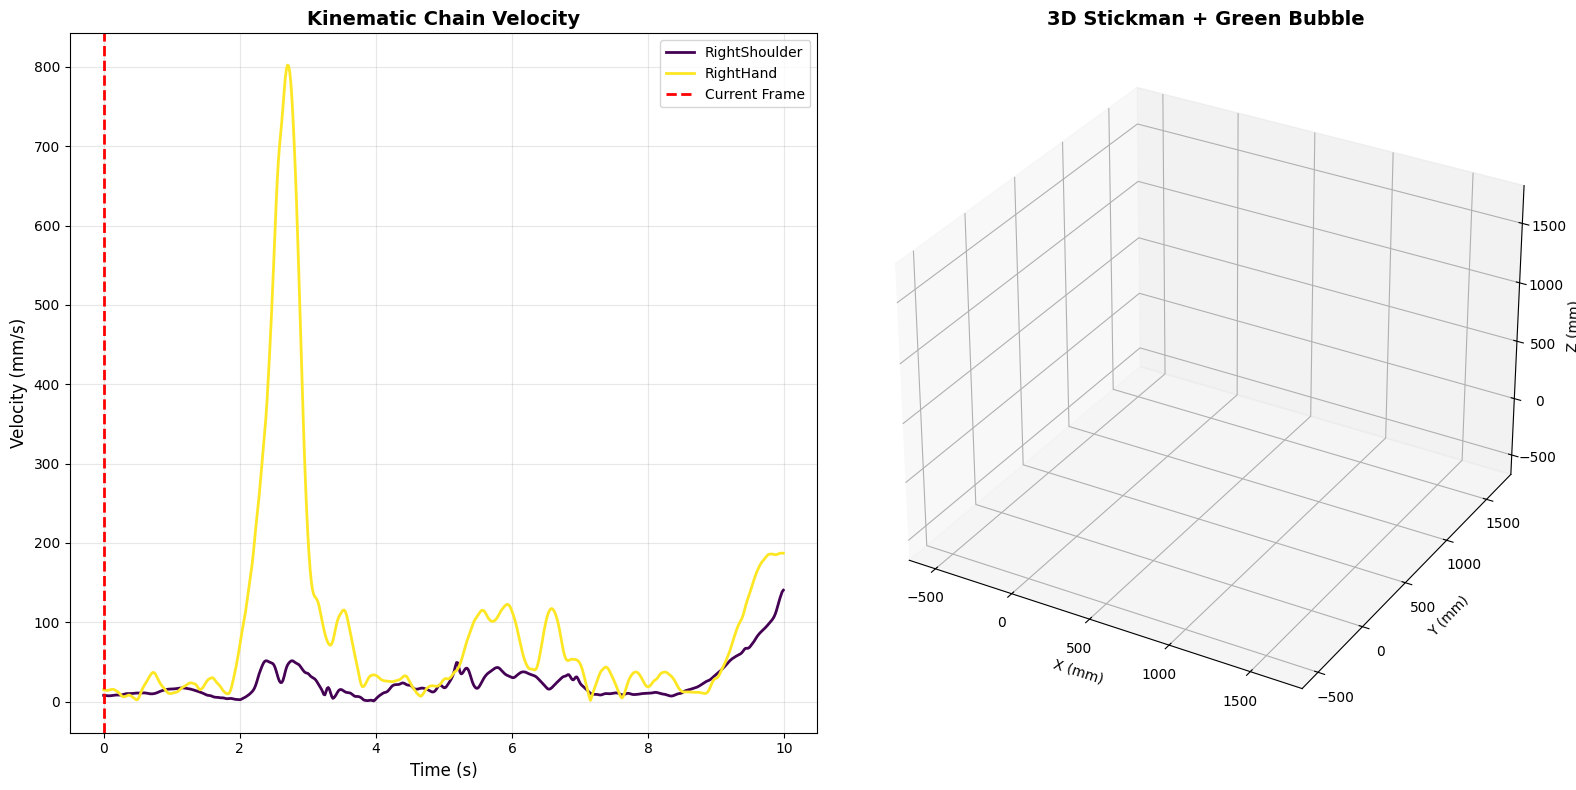

In [6]:
# =============================================================================
# DASHBOARD SETUP
# =============================================================================

# Create figure with 2 subplots
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax_left = fig.add_subplot(121)    # Panel 1: Feature plot
ax_right = fig.add_subplot(122, projection='3d')  # Panel 2: 3D stickman

# =============================================================================
# PANEL 1: FEATURE PLOT (LEFT)
# =============================================================================

if MODE == 'velocity':
    # Plot velocity for each joint in the chain
    colors = plt.cm.viridis(np.linspace(0, 1, len(velocity_data)))
    lines = []
    for i, (joint, v_mag) in enumerate(velocity_data.items()):
        line, = ax_left.plot(time_axis, v_mag, color=colors[i], label=joint, linewidth=2)
        lines.append(line)
    
    ax_left.set_xlabel('Time (s)', fontsize=12)
    ax_left.set_ylabel('Velocity (mm/s)', fontsize=12)
    ax_left.set_title('Kinematic Chain Velocity', fontsize=14, fontweight='bold')
    ax_left.legend(loc='upper right')
    ax_left.grid(True, alpha=0.3)

elif MODE == 'volume':
    # Plot volume over time
    line_vol, = ax_left.plot(time_axis, volume_data, color='dodgerblue', linewidth=2)
    ax_left.set_xlabel('Time (s)', fontsize=12)
    ax_left.set_ylabel('Volume (mm³)', fontsize=12)
    ax_left.set_title('Convex Hull Volume', fontsize=14, fontweight='bold')
    ax_left.grid(True, alpha=0.3)

# Sync pointer (vertical line)
vline = ax_left.axvline(x=time_axis[0], color='red', linewidth=2, linestyle='--', label='Current Frame')
ax_left.legend()

# =============================================================================
# PANEL 2: 3D STICKMAN (RIGHT)
# =============================================================================

# Initialize skeleton lines
skeleton_lines = []
for joint1, joint2 in SKELETON_MAP:
    line, = ax_right.plot([], [], [], 'b-', linewidth=2)
    skeleton_lines.append((joint1, joint2, line))

# Initialize joint markers
joint_scatter = ax_right.scatter([], [], [], c='red', s=50, alpha=0.8)

# Initialize convex hull (green bubble)
hull_collection = None

# Set 3D axis properties
ax_right.set_xlabel('X (mm)', fontsize=10)
ax_right.set_ylabel('Y (mm)', fontsize=10)
ax_right.set_zlabel('Z (mm)', fontsize=10)
ax_right.set_title('3D Stickman + Green Bubble', fontsize=14, fontweight='bold')

# Set axis limits (will be updated dynamically)
all_positions = []
for marker in marker_names:
    for axis in ['__px', '__py', '__pz']:
        col = f"{marker}{axis}"
        if col in df_subset.columns:
            all_positions.extend(df_subset[col].dropna().values)

if all_positions:
    margin = 200  # mm
    p_min, p_max = np.min(all_positions), np.max(all_positions)
    ax_right.set_xlim(p_min - margin, p_max + margin)
    ax_right.set_ylim(p_min - margin, p_max + margin)
    ax_right.set_zlim(p_min - margin, p_max + margin)

# Frame counter text
frame_text = ax_right.text2D(0.05, 0.95, '', transform=ax_right.transAxes, fontsize=12, 
                             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
print("✅ Dashboard initialized")

## Animation Function

In [7]:
# =============================================================================
# ANIMATION UPDATE FUNCTION
# =============================================================================

def update_frame(frame_idx):
    """Update both panels for the current frame."""
    global hull_collection
    
    # Update vertical line in left panel (sync pointer)
    vline.set_xdata([time_axis[frame_idx], time_axis[frame_idx]])
    
    # Update 3D stickman (right panel)
    # 1. Update skeleton lines
    for joint1, joint2, line in skeleton_lines:
        pos1 = get_joint_position(df_subset, joint1, frame_idx)
        pos2 = get_joint_position(df_subset, joint2, frame_idx)
        
        if pos1 is not None and pos2 is not None:
            if not np.any(np.isnan(pos1)) and not np.any(np.isnan(pos2)):
                line.set_data([pos1[0], pos2[0]], [pos1[1], pos2[1]])
                line.set_3d_properties([pos1[2], pos2[2]])
            else:
                line.set_data([], [])
                line.set_3d_properties([])
        else:
            line.set_data([], [])
            line.set_3d_properties([])
    
    # 2. Update joint markers
    joint_positions = []
    for marker in marker_names:
        pos = get_joint_position(df_subset, marker, frame_idx)
        if pos is not None and not np.any(np.isnan(pos)):
            joint_positions.append(pos)
    
    if joint_positions:
        joint_positions = np.array(joint_positions)
        joint_scatter._offsets3d = (joint_positions[:, 0], 
                                    joint_positions[:, 1], 
                                    joint_positions[:, 2])
    
    # 3. Update convex hull (green bubble)
    if hull_collection is not None:
        hull_collection.remove()
        hull_collection = None
    
    hull_faces = get_convex_hull_mesh(df_subset, marker_names, frame_idx)
    if hull_faces is not None:
        hull_collection = Poly3DCollection(hull_faces, 
                                          facecolors='lime', 
                                          alpha=0.2, 
                                          edgecolors='green', 
                                          linewidths=0.5)
        ax_right.add_collection3d(hull_collection)
    
    # 4. Update frame counter
    actual_frame = START_FRAME + frame_idx * STEP
    frame_text.set_text(f'Frame: {actual_frame}\nTime: {time_axis[frame_idx]:.2f}s')
    
    return [vline] + [line for _, _, line in skeleton_lines] + [joint_scatter, frame_text]

print("✅ Animation function defined")

✅ Animation function defined


## Run Animation

**Execute the cell below to display the animated dashboard**

In [ ]:
# =============================================================================
# RUN ANIMATION
# =============================================================================

# Create animation
anim = animation.FuncAnimation(
    fig, 
    update_frame, 
    frames=len(df_subset),
    interval=1000/FPS,  # milliseconds per frame
    blit=False,
    repeat=True
)

# Display in notebook
from IPython.display import HTML
HTML(anim.to_jshtml())

print(f"✅ Animation created: {len(df_subset)} frames at {FPS} FPS")
print(f"   Duration: {len(df_subset)/FPS:.1f} seconds")

Animation size has reached 21067029 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


## Save Animation (Optional)

**Uncomment and run to save as video file**

In [ ]:
# =============================================================================
# SAVE ANIMATION (OPTIONAL)
# =============================================================================

# # Output directory
# ANALYSIS_DIR = os.path.join(PROJECT_ROOT, "analysis")
# os.makedirs(ANALYSIS_DIR, exist_ok=True)

# # Save as MP4 (requires ffmpeg)
# output_file = os.path.join(ANALYSIS_DIR, f"{RUN_ID}_dashboard_{MODE}.mp4")
# print(f"Saving animation to: {output_file}")
# print("This may take a few minutes...")

# anim.save(output_file, writer='ffmpeg', fps=FPS, dpi=DPI)
# print(f"✅ Animation saved: {output_file}")

# # Alternative: Save as GIF (slower, larger file size)
# # output_gif = os.path.join(ANALYSIS_DIR, f"{RUN_ID}_dashboard_{MODE}.gif")
# # anim.save(output_gif, writer='pillow', fps=FPS//2)  # Lower FPS for GIF
# # print(f"✅ GIF saved: {output_gif}")

## Static Snapshot (Optional)

**Save a single frame as PNG**

In [ ]:
# =============================================================================
# SAVE STATIC SNAPSHOT
# =============================================================================

# Select a representative frame (e.g., middle of sequence)
snapshot_frame = len(df_subset) // 2

# Update to that frame
update_frame(snapshot_frame)

# Save figure
ANALYSIS_DIR = os.path.join(PROJECT_ROOT, "analysis")
os.makedirs(ANALYSIS_DIR, exist_ok=True)
output_png = os.path.join(ANALYSIS_DIR, f"{RUN_ID}_dashboard_{MODE}_snapshot.png")
plt.savefig(output_png, dpi=150, bbox_inches='tight')
print(f"✅ Snapshot saved: {output_png}")
print(f"   Frame: {snapshot_frame} ({time_axis[snapshot_frame]:.2f}s)")

## Summary

**Dashboard Specifications**:
- Mode: velocity or volume
- Synchronized dual-panel visualization
- 3D stickman with convex hull envelope
- Frame-accurate time synchronization
- Configurable frame range and kinematic chains

**Customization Tips**:
1. Change `MODE` to 'velocity' or 'volume'
2. Modify `JOINTS_TO_PLOT` for different kinematic chains
3. Adjust `START_FRAME`, `END_FRAME`, `STEP` for frame range
4. Edit `SKELETON_MAP` to customize skeleton connections
5. Change `FPS` for animation speed

**Output Files**:
- Animation: `{RUN_ID}_dashboard_{MODE}.mp4` (if saved)
- Snapshot: `{RUN_ID}_dashboard_{MODE}_snapshot.png`